In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from yellowbrick.features import FeatureImportances
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import model_selection
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from seaborn import heatmap
import rfpimp
from yellowbrick.regressor import PredictionError
import itertools
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
%matplotlib inline
plt.style.use('ggplot')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
data = pd.read_csv('bo.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                           3442 non-null   object 
 6   space                             2528 non-null   object 
 7   description                       3585 non-null   object 
 8   experiences_offered               3585 non-null   object 
 9   neighborhood_overview             2170 non-null   object 
 10  notes                             1610 non-null   object 
 11  transit                           2295 non-null   object 
 12  access

In [4]:
#make subset based on our goal
data_v1 = data[['neighbourhood','is_location_exact','host_is_superhost','property_type','room_type'
            ,'instant_bookable','cancellation_policy','accommodates','bathrooms'
            ,'bedrooms','extra_people','minimum_nights','maximum_nights'
            ,'security_deposit','price']]

In [5]:
#check missing values
data_v1.isnull().sum()

neighbourhood           543
is_location_exact         0
host_is_superhost         0
property_type             3
room_type                 0
instant_bookable          0
cancellation_policy       0
accommodates              0
bathrooms                14
bedrooms                 10
extra_people              0
minimum_nights            0
maximum_nights            0
security_deposit       2243
price                     0
dtype: int64

In [6]:
print('The percentage of missing values of security_deposit column: ')
print(2243/3585)

The percentage of missing values of security_deposit column: 
0.6256624825662482


In [7]:
#based on the percentage, we decide to drop the security_deposit col
data_v2 = data_v1.drop(columns = 'security_deposit')

In [8]:
#check each unique value of property_type
data_v2.property_type.value_counts()

Apartment          2612
House               562
Condominium         231
Townhouse            54
Bed & Breakfast      41
Loft                 39
Other                17
Boat                 12
Villa                 6
Entire Floor          4
Dorm                  2
Guesthouse            1
Camper/RV             1
Name: property_type, dtype: int64

In [9]:
#extract the most popular property type
data_v3 = data_v2[(data_v2['property_type']=='House') | (data_v2['property_type']=='Apartment') | (data_v2['property_type'] == 'Townhouse')
                 |(data_v2['property_type']=='Condominium')|(data_v2['property_type']=='Loft')]

In [10]:
#check each unique value of neighbourhood
data_v3.neighbourhood.value_counts()

Allston-Brighton      359
Jamaica Plain         303
South End             289
Back Bay              285
Fenway/Kenmore        248
South Boston          208
Dorchester            190
Beacon Hill           171
North End             120
Roxbury               113
East Boston           112
Mission Hill          103
Chinatown              78
Charlestown            76
West End               68
Roslindale             49
West Roxbury           35
Theater District       32
Downtown Crossing      25
Hyde Park              25
Mattapan               20
Somerville             12
Leather District        8
Cambridge               7
Financial District      7
Brookline               7
Downtown                6
Chestnut Hill           4
Government Center       3
Harvard Square          2
Name: neighbourhood, dtype: int64

In [11]:
#extract the top 12 popular neighbourhood
data_v4 = data_v3[(data_v3['neighbourhood']=='Allston-Brighton') | (data_v3['neighbourhood']=='Jamaica Plain') | (data_v3['neighbourhood']=='South End')
                 |(data_v3['neighbourhood']=='Back Bay')|(data_v3['neighbourhood']=='Fenway/Kenmore') | (data_v3['neighbourhood']=='South Boston')
                 |(data_v3['neighbourhood']=='Dorchester') |(data_v3['neighbourhood']=='Beacon Hill')|(data_v3['neighbourhood']=='North End')
                 |(data_v3['neighbourhood']=='Roxbury')|(data_v3['neighbourhood']=='East Boston ')|(data_v3['neighbourhood']=='Mission Hill')]

In [12]:
#drop any missing values
data_v5 = data_v4.dropna(axis=0,how='any')

In [13]:
#data preprocessing
#One hot encoding for categorical values:
#1.
is_location_exactMap = {elem:index for index,elem in enumerate(set(data_v5["is_location_exact"]))}
data_v5["is_location_exact"] = data_v5["is_location_exact"].map(is_location_exactMap)

#2.
host_is_superhostMap = {elem:index for index,elem in enumerate(set(data_v5["host_is_superhost"]))}
data_v5["host_is_superhost"] = data_v5["host_is_superhost"].map(host_is_superhostMap)

#3.
instant_bookableMap = {elem:index for index,elem in enumerate(set(data_v5["instant_bookable"]))}
data_v5["instant_bookable"] = data_v5["instant_bookable"].map(instant_bookableMap)

#4.
data_v5[['property_type','room_type','cancellation_policy','neighbourhood']] = data_v5[['property_type','room_type','cancellation_policy','neighbourhood']].apply(LabelEncoder().fit_transform)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [14]:
#define function:
#striping extra_peopel and price cols
def dollar_sign_replace(xstr):
    return xstr.replace('$','')
def comma_replace(xstr):
    return xstr.replace(',','')

In [15]:
#1
data_v5['price'] = data_v5['price'].apply(dollar_sign_replace)
data_v5['extra_people'] = data_v5['extra_people'].apply(dollar_sign_replace)
#2
data_v5['price'] = data_v5['price'].apply(comma_replace)
data_v5['extra_people'] = data_v5['extra_people'].apply(comma_replace)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [16]:
#3. convert price from str to numerical data type
data_v5['price'] = data_v5['price'].astype(float)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
#standardlize numerical data
std = StandardScaler()
#1.
minimum_nights_param = std.fit(data_v5['minimum_nights'].values.reshape(-1, 1))
data_v5['minimum_nights'] = std.fit_transform(data_v5['minimum_nights'].values.reshape(-1, 1), minimum_nights_param)
#2.
maximum_nights_param = std.fit(data_v5['maximum_nights'].values.reshape(-1, 1))
data_v5['maximum_nights'] = std.fit_transform(data_v5['maximum_nights'].values.reshape(-1, 1), maximum_nights_param)
#3.
extra_people_param = std.fit(data_v5['extra_people'].values.reshape(-1, 1))
data_v5['extra_people'] = std.fit_transform(data_v5['extra_people'].values.reshape(-1, 1), extra_people_param)
#more standardlize :
neighbourhood_param = std.fit(data_v5['neighbourhood'].values.reshape(-1, 1))
data_v5['neighbourhood'] = std.fit_transform(data_v5['neighbourhood'].values.reshape(-1, 1), neighbourhood_param)

accommodates_param = std.fit(data_v5['accommodates'].values.reshape(-1, 1))
data_v5['accommodates'] = std.fit_transform(data_v5['accommodates'].values.reshape(-1, 1), accommodates_param)

bathrooms_param = std.fit(data_v5['bathrooms'].values.reshape(-1, 1))
data_v5['bathrooms'] = std.fit_transform(data_v5['bathrooms'].values.reshape(-1, 1), bathrooms_param)

bedrooms_param = std.fit(data_v5['bedrooms'].values.reshape(-1, 1))
data_v5['bedrooms'] = std.fit_transform(data_v5['bedrooms'].values.reshape(-1, 1), bedrooms_param)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [18]:
#split into train and test:
y = data_v5.price
x = data_v5.drop(columns = ['price'], axis =1)

#split into train and test set
x_train,x_test,y_train,y_test = model_selection.train_test_split(x,y,test_size = 0.25,random_state = 42)

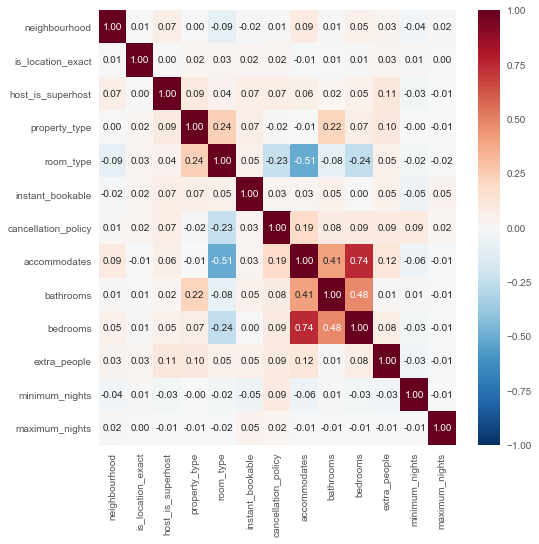

In [19]:
#correlations:
fig, ax = plt.subplots(figsize=(8,8))
ax=heatmap(x.corr(),fmt='.2f',annot=True,ax=ax,cmap="RdBu_r",vmin=-1,vmax=1)

In [20]:
x.corr().iloc[:,:13]

,neighbourhood,is_location_exact,host_is_superhost,property_type,room_type,instant_bookable,cancellation_policy,accommodates,bathrooms,bedrooms,extra_people,minimum_nights,maximum_nights
neighbourhood,1.000000,0.005604,0.066042,0.004055,-0.091675,-0.021133,0.012890,0.087078,0.008147,0.050898,0.034505,-0.037135,0.015005
is_location_exact,0.005604,1.000000,0.001129,0.021448,0.026296,0.024256,0.023926,-0.014975,0.006860,0.014551,0.028574,0.010181,0.001752
host_is_superhost,0.066042,0.001129,1.000000,0.093800,0.039926,0.074509,0.070953,0.056241,0.021788,0.049216,0.110916,-0.027648,-0.007677
property_type,0.004055,0.021448,0.093800,1.000000,0.240284,0.065465,-0.016647,-0.006057,0.220950,0.067096,0.104859,-0.002417,-0.010571
room_type,-0.091675,0.026296,0.039926,0.240284,1.000000,0.052373,-0.233101,-0.507539,-0.079730,-0.243227,0.054240,-0.024166,-0.015611
instant_bookable,-0.021133,0.024256,0.074509,0.065465,0.052373,1.000000,0.027633,0.026646,0.047501,0.003691,0.053722,-0.054008,0.046274
cancellation_policy,0.012890,0.023926,0.070953,-0.016647,-0.233101,0.027633,1.000000,0.192081,0.078723,0.093122,0.093328,0.088131,0.017954
accommodates,0.087078,-0.014975,0.056241,-0.006057,-0.507539,0.026646,0.192081,1.000000,0.408886,0.742722,0.121405,-0.055141,-0.011972
bathrooms,0.008147,0.006860,0.021788,0.220950,-0.079730,0.047501,0.078723,0.408886,1.000000,0.483852,0.008483,0.011914,-0.009529
bedrooms,0.050898,0.014551,0.049216,0.067096,-0.243227,0.003691,0.093122,0.742722,0.483852,1.000000,0.075101,-0.025026,-0.006580


In [21]:
#build baseline model
dr = DummyRegressor()
dr.fit(x_train,y_train)
dr.score(x_test,y_test)
#negative means bad model

-0.00037963941458452055

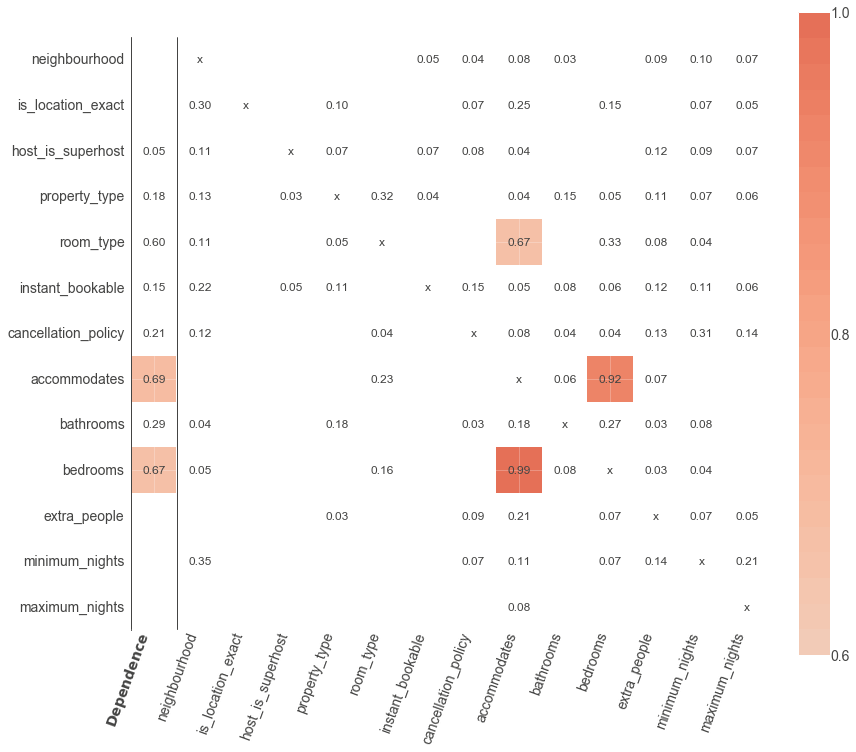

In [22]:
#feature selection: collinear
rfpimp.plot_dependence_heatmap(
    rfpimp.feature_dependence_matrix(x_train),
    value_fontsize=12,
    label_fontsize=14,
    figsize=(12, 12)
)
fig = plt.gcf()
#the result shows we should remove bedrooms, since value is close to 1

In [23]:
data_v6 = data_v5.drop(columns ='accommodates')

In [24]:
y2 = data_v6.price
x2 = data_v6.drop(columns = ['price'], axis =1)

#split into train and test set
x2_train,x2_test,y2_train,y2_test = model_selection.train_test_split(x2,y2,test_size = 0.25,random_state = 42)

In [25]:
lr = LinearRegression()
lr.fit(x2_train,y2_train)
#check the testingset result
lr.score(x2_test,y2_test)

0.3277058214488898

In [26]:
lr.coef_

array([  6.43131069, -78.29225708,  13.81375757, -11.03681454,
       -93.65511134, -23.14924015,   5.67205834,  28.9152894 ,
        34.87467562,   6.13551597,  -7.04300718,  -1.18360588])

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


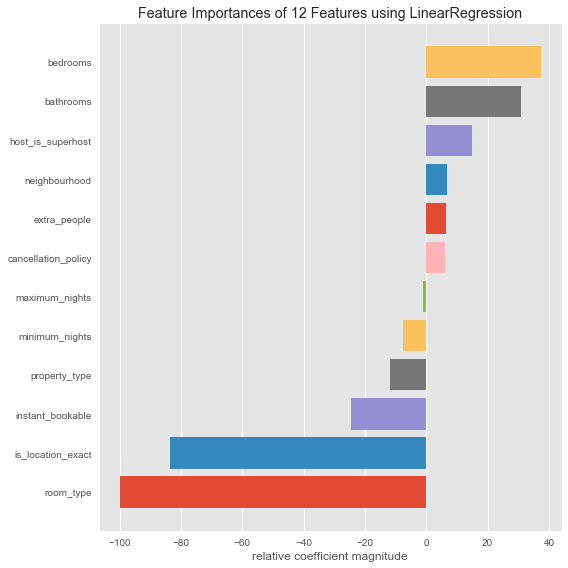

In [27]:
#check the feature importance
fig, ax = plt.subplots(figsize = (8,8))
fi_viz = FeatureImportances(lr, labels = x2.columns)
fi_viz.fit(x2,y)
fi_viz.poof()

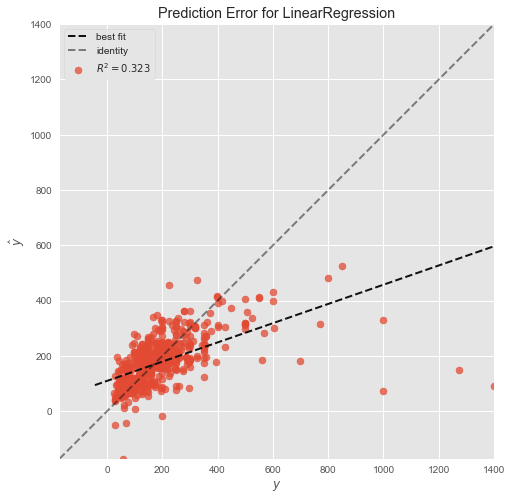

In [28]:
#prediction Error plot
fig, ax = plt.subplots(figsize = (8,8))
pev = PredictionError(lr)
pev.fit(x2_train,y2_train)
pev.score(x2_test,y2_test)
pev.poof()

In [38]:
#forward stepwise:
#1.define function returns necessary values
def fit_linear_reg(X,Y):
    #Fit linear regression model and return RSS and R squared values
    model_k = LinearRegression(fit_intercept = True)
    model_k.fit(X,Y)
    RSS = mean_squared_error(Y,model_k.predict(X)) * len(Y)
    R_squared = model_k.score(X,Y)
    return RSS, R_squared

In [39]:
#Initialization variables
k = 12 #iteration times
remaining_features = list(x2.columns.values)
features = []
RSS_list, R_squared_list = [np.inf], [np.inf] #Due to 1 indexing of the loop...
features_list = dict()

for i in range(1,k+1):
    best_RSS = np.inf
    
    for combo in itertools.combinations(remaining_features,1):

            RSS = fit_linear_reg(x2[list(combo) + features],y2)   #Store temp result 

            if RSS[0] < best_RSS:
                best_RSS = RSS[0]
                best_R_squared = RSS[1] 
                best_feature = combo[0]

    #Updating variables for next loop
    features.append(best_feature)
    remaining_features.remove(best_feature)
    
    #Saving values for plotting
    RSS_list.append(best_RSS)
    R_squared_list.append(best_R_squared)
    features_list[i] = features.copy()

In [40]:
#dispalying the results
print('Forward stepwise subset selection')
print('Number of features |', 'Features |', 'RSS')
display([(i,features_list[i], round(RSS_list[i])) for i in range(1,5)])

Forward stepwise subset selection
Number of features | Features | RSS


[(1, ['room_type'], 53579941.0),
 (2, ['room_type', 'bedrooms'], 48038280.0),
 (3, ['room_type', 'bedrooms', 'bathrooms'], 46740687.0),
 (4, ['room_type', 'bedrooms', 'bathrooms', 'instant_bookable'], 46496956.0)]